In [1]:
# Standard packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Standard preprocessing and modeling imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Neural Network imports
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping

# Disable warning messages
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Clean dataframe for modeling

In [2]:
# Read in master csv
master = pd.read_csv('./data/all_master_files')
# Drop Unnamed:0 column
master.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
master.shape

(4427, 15)

In [4]:
master.head()

,title,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,time_signature,duration_sec,hit
0,All Time Low,0.584,0.569,-4.259,1.0,0.1660,0.0508,0.000000,0.0924,0.501,89.779,0.0,4.0,217.603,1
1,Bleeding Love,0.638,0.656,-5.886,1.0,0.0357,0.1880,0.000000,0.1460,0.225,104.036,5.0,4.0,262.467,1
2,No One Compares To You,0.703,0.748,-6.047,1.0,0.0435,0.1230,0.000000,0.0642,0.625,111.943,1.0,4.0,184.080,1
3,Lollipop,0.828,0.433,-9.716,1.0,0.1990,0.0656,0.000876,0.1220,0.440,148.073,0.0,4.0,299.333,1
4,Apologize,0.591,0.718,-6.025,1.0,0.0368,0.3480,0.000118,0.1070,0.468,117.995,8.0,4.0,208.107,1


In [5]:
# Drop duplicates
master.drop_duplicates(inplace=True)
master.shape

(3129, 15)

# Building a neural network to predict hit songs

**Train Test Split**

In [6]:
# Set X features and y variable to predict
features = master.columns.drop(['title','hit'])
X = master[features]
y = master['hit']

In [7]:
# Instantiate train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
# Baseline score
y.value_counts(normalize=True)

0    0.905081
1    0.094919
Name: hit, dtype: float64

**Alleviate imbalanced classes**

In [9]:
# Our y variable is very imbalanced
pd.Series(y).value_counts()

0    2832
1     297
Name: hit, dtype: int64

In [10]:
# Instantiate and fit SMOTE to oversample the minority class
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [11]:
# Classes are now balanced
pd.Series(y_train_smote).value_counts()

1    2118
0    2118
dtype: int64

**Standard Scaler**

In [12]:
# Instantiate Standard Scaler
ss = StandardScaler()
# Fit and transform training features
X_train_sc = ss.fit_transform(X_train_smote)
# Transform test features
X_test_sc = ss.transform(X_test)

**Build Neural Network**

In [20]:
# Instantiate the Sequential Neural Net
model = Sequential()
# Create the input and first hidden layer
model.add(Dense(4236, 
                activation='relu', 
                input_dim=X_train_sc.shape[1]))
# Add hidden layer
model.add(Dense(1900, activation='relu'))
# Add hidden layer
model.add(Dense(200, activation='relu'))
# Add hidden layer
# model.add(Dense(50, activation='relu'))
# Instantiate a Dropout regularizer
model.add(Dropout(0.5))
# Create output layer
model.add(Dense(1, activation='sigmoid'))

In [21]:
# Compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# Instantiate EarlyStopping
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2)

In [23]:
# Fit the neural net
results = model.fit(X_train_sc, y_train_smote, 
                    validation_data=(X_test_sc, y_test), 
                    epochs = 15,
                    callbacks=[early])

Train on 4236 samples, validate on 783 samples
Epoch 1/15
4236/4236 [==============================] - 32s 8ms/step - loss: 0.5531 - acc: 0.7198 - val_loss: 0.6667 - val_acc: 0.5964
Epoch 2/15
4236/4236 [==============================] - 33s 8ms/step - loss: 0.4626 - acc: 0.7847 - val_loss: 0.5189 - val_acc: 0.7190
Epoch 3/15
4236/4236 [==============================] - 32s 7ms/step - loss: 0.4109 - acc: 0.8102 - val_loss: 0.4998 - val_acc: 0.7880
Epoch 4/15
4236/4236 [==============================] - 32s 8ms/step - loss: 0.3455 - acc: 0.8428 - val_loss: 0.5878 - val_acc: 0.7778
Epoch 5/15
4236/4236 [==============================] - 31s 7ms/step - loss: 0.3103 - acc: 0.8647 - val_loss: 0.5615 - val_acc: 0.7497


In [24]:
# Generate model predictions 
preds = model.predict(X_test_sc)

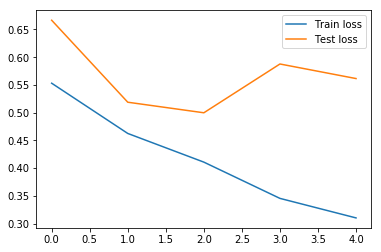

In [25]:
# Plot the results 
plt.plot(results.history['loss'], label='Train loss');
plt.plot(results.history['val_loss'], label='Test loss');
plt.legend();

# GridSearch a logistic regression model using audio features for interpretability 

In [26]:
# Build logistic regression parameters for Gridsearch
params = {
    'penalty': ['l1', 'l2'],
    'C': [1, 5, 10]
}

In [27]:
# Instantiate Gridsearch for logistic regression
gs = GridSearchCV(estimator=LogisticRegression(),
                 param_grid=params)

In [28]:
# Fit the GridSearch model
gs.fit(X_train_sc, y_train_smote)
# Print the best accuracy score
print('The best score is: ', gs.best_score_)
# Print the best parameters to use
print('The best parameters to use are: ', gs.best_params_)
# Generate model predictions
gs_preds = gs.predict(X_test_sc)
# Print the recall score
print('The recall score is: ', recall_score(y_test, gs_preds))

The best score is:  0.6857884796978282
The best parameters to use are:  {'C': 5, 'penalty': 'l2'}
The recall score is:  0.6231884057971014


In [29]:
# Create a logistic regression model with the best parameters
lr = LogisticRegression(C=5)
# Fit the model
lr.fit(X_train_sc, y_train_smote)
# Print accuracy score
print('The accuracy score is: ', lr.score(X_test_sc, y_test))


The accuracy score is:  0.6283524904214559


In [30]:
# Create a dataframe with feature coefficients to see which features have most influence on a hit song
coef_df = pd.DataFrame(lr.coef_, columns=features, index=['coefficients']).T.sort_values('coefficients')
coef_df

,coefficients
energy,-0.627122
instrumentalness,-0.342719
acousticness,-0.154411
valence,-0.071294
tempo,-0.065701
duration_sec,-0.033974
liveness,-0.021042
time_signature,0.052033
mode,0.083846
speechiness,0.101722


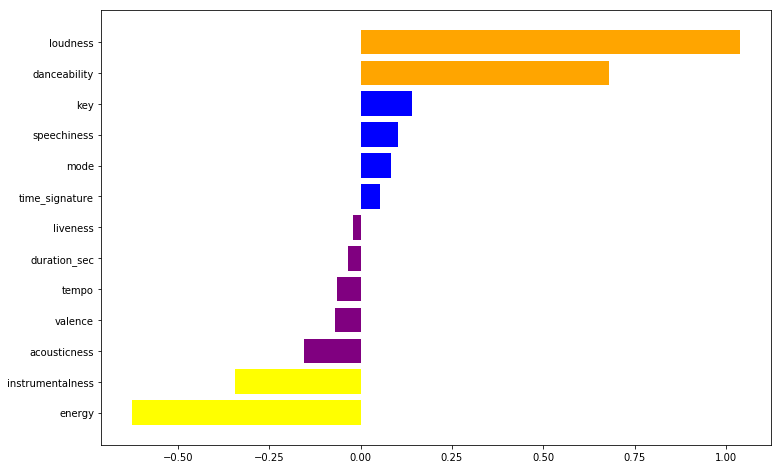

In [62]:
# Horizontal bar chart
plt.figure(figsize=(12,8))
plt.barh(coef_df.index, coef_df['coefficients'], 
         color=['yellow', 'yellow', 'purple', 'purple', 'purple', 'purple', 'purple', 
                'blue', 'blue', 'blue', 'blue', 'orange', 'orange']);

In [32]:
y_test.value_counts()

0    714
1     69
Name: hit, dtype: int64

In [33]:
# Generate a confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, gs_preds), 
                  columns=['predicted not hit', 'predicted hit'],
                  index=['actual not hit', 'actual hit'])
# Print the recall score
print('The recall score is: ', recall_score(y_test, gs_preds))
cm

The recall score is:  0.6231884057971014


,predicted not hit,predicted hit
actual not hit,449,265
actual hit,26,43


# Building a logistic regression model to analyze song lyrics

In [41]:
# Read in data
master_08 = pd.read_csv('./data/MASTER_2008_lyrics')
master_13 = pd.read_csv('./data/MASTER_2013_lyrics')
master_18 = pd.read_csv('./data/MASTER_2018_lyrics')

# Concatenate all lyrics files
master_lyrics = pd.concat([master_08, master_13, master_18])

In [35]:
# Drop 'Unnamed: 0' column
master_18.drop('Unnamed: 0', axis=1, inplace=True)
master_13.drop('Unnamed: 0', axis=1, inplace=True)
master_08.drop('Unnamed: 0', axis=1, inplace=True)

In [36]:
# Check for imbalanced classes 
print(master_18['hit'].value_counts())
print('')
print(master_13['hit'].value_counts())
print('')
print(master_08['hit'].value_counts())

0    1373
1      98
Name: hit, dtype: int64

0    2696
1      95
Name: hit, dtype: int64

0    1935
1      98
Name: hit, dtype: int64


In [86]:
'''
Create a function that preprocesses the dataset for modeling, remedies imbalanced classes, models the data
and returns a confusion matrix with the printed recall score
'''
def lyrics_model(df):
    # Set X and y and train test split
    X = df['tokenized_lyrics']
    y= df['hit']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Instantiate CountVectorizer
    cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,5))
    # Fit and transform features from training data
    X_train_cv = cv.fit_transform(X_train)
    # Transform features from testing data
    X_test_cv = cv.transform(X_test)
    
    # Instantiate SMOTE to remedy imbalanced classes and resample minority class
    sm = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_smote, y_train_smote = sm.fit_resample(X_train_cv, y_train)
    
    # Instantiate logistic regression
    lr = LogisticRegression()
    # Fit the model
    lr.fit(X_train_smote, y_train_smote)
    # Print the model's accuracy score 
    print('The accuracy score is: ', lr.score(X_test_cv, y_test))
    # Create predictions
    preds = lr.predict(X_test_cv)
    # Print the recall score
    print('The recall score is: ', recall_score(y_test, preds))
    
    # Create a confusion matrix
    cm = pd.DataFrame(confusion_matrix(y_test, preds), 
                      columns=['predicted not hit', 'predicted hit'],
                      index=['actual not hit', 'actual hit'])
    return cm   # Return confusion matrix

In [83]:
lyrics_model(master_08)

The accuracy score is:  0.9194499017681729
The recall score is:  0.0


,predicted not hit,predicted hit
actual not hit,468,20
actual hit,21,0


In [84]:
lyrics_model(master_13)

The accuracy score is:  0.9541547277936963
The recall score is:  0.047619047619047616


,predicted not hit,predicted hit
actual not hit,665,12
actual hit,20,1


In [78]:
lyrics_model(master_18)

The accuracy score is:  0.9483695652173914
The recall score is:  0.391304347826087


,predicted not hit,predicted hit
actual not hit,340,5
actual hit,14,9


In [87]:
lyrics_model(master_lyrics)

The accuracy score is:  0.9390088945362135
The recall score is:  0.08


,predicted not hit,predicted hit
actual not hit,1472,27
actual hit,69,6


In [53]:
X2 = master_lyrics['tokenized_lyrics']
y2 = master_lyrics['hit']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

# Instantiate CountVectorizer
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,5))
# Fit and transform features from training data
X2_train_cv = cv.fit_transform(X2_train)
# Transform features from testing data
X2_test_cv = cv.transform(X2_test)

# Instantiate SMOTE to remedy imbalanced classes and resample minority class
sm2 = SMOTE(sampling_strategy='minority', random_state=42)
X2_train_smote, y2_train_smote = sm2.fit_resample(X2_train_cv, y2_train)

# Instantiate logistic regression
lr2 = LogisticRegression()
# Fit the model
lr2.fit(X2_train_smote, y2_train_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [74]:
lr2.coef_

[array([-0.01335648, -0.00323555, -0.00323555, ..., -0.00081564,
        -0.00081564, -0.00081564])]

# Build clustering algorithm for lyrics 

In [49]:
# Set X and y and train test split
X = master_lyrics['tokenized_lyrics']
y = master_lyrics['hit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instantiate CountVectorizer
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,5))
# Fit and transform features from training data
X_train_cv = cv.fit_transform(X_train)
# Transform features from testing data
X_test_cv = cv.transform(X_test)

# Instantiate SMOTE to remedy imbalanced classes and resample minority class
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_cv, y_train)

In [50]:
# Instantiate KMeans
kmeans = KMeans(n_clusters=10)
# Fit the model
kmeans.fit(X_train_smote)
# Create cluster predictions
preds = kmeans.predict(X_test_cv)
print(preds)
# Get centroids
centroids = kmeans.cluster_centers_
print(centroids)

[1 1 1 ... 1 1 1]
[[0.08333333 0.         0.         ... 0.         0.         0.        ]
 [0.00044658 0.00011164 0.00011164 ... 0.00011164 0.00011164 0.00011164]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [52]:
preds.shape

(1574,)

In [ ]:
plt.figure()